In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import time
from matplotlib.colors import ListedColormap
import tqdm

In [18]:
plask = np.load("themap.npy")

def albedo(N, M):
    # assuming perpendicular
    albedo_ocean = 0.06
    albedo_ice = 0.8
    albedo_land = 0.25
    A = np.zeros((N,M)) + albedo_ocean
    
    for i in range(N):
        for j in range(M):
            if plask[i, j] == 1:
                A[i, j] = albedo_land
            elif plask[i, j] == 2:
                A[i, j] = albedo_ice
            
    return A

def insolation(N,M):
    # not dependent of time atm, but dependent of latitude
    a = np.linspace(0.1, 1, int(N/2)+1)
    b = np.linspace(1,0.1, int(N/2))
    inssol = np.concatenate((a,b), axis = 0)
    A = np.column_stack([inssol] * M) 
    return A

# changed D0 by + 0.1

def diffusion(N,M,D0 = 0.91, D2 = -1.33 , D4 = 0.67):
    def D(x): # the difusion function
        return D0 * ( 1 + D2 * x**2 + D4 * x**4)
    
    A = np.linspace(1, 0.1, int(N/2)+1) # plus one cause not modulus
    B = np.linspace(0.1, 1, int(N/2)) # makking the difusion highest at equator, and lowest at the poles
    sol = np.concatenate((A,B), axis = 0)
    A = np.column_stack([D(sol)] * M) 
    return A

def createTemp(N,M, T=290):
    # beriodic BC
    b = np.linspace(0.9,1.1,int(N/2)+1)
    c = np.linspace(1.1,0.9,int(N/2))
    d = np.concatenate((b,c), axis = 0)
    return T * np.column_stack([d]*M)


def createC(N, M, C_ocean = 8e3, C_ice = 6e3, C_land = 1e3):
    
    A = np.zeros((N,M)) + C_ocean
    
    for i in range(N):
        for j in range(M):
            if plask[i, j] == 1:
                A[i, j] = C_land
            elif plask[i, j] == 2:
                A[i, j] = C_ice
    return A


@njit
def custom_roll_2d(arr, shift, axis=0):
    if axis == 0:
        result = np.empty_like(arr)
        for i in range(arr.shape[0]):
            result[i] = arr[(i - shift) % arr.shape[0]]
        return result
    elif axis == 1:
        result = np.empty_like(arr)
        for i in range(arr.shape[1]):
            result[:, i] = arr[:, (i - shift) % arr.shape[1]]
        return result
    else:
        raise ValueError("Axis should be 0 or 1")

In [26]:
@njit
def main(C,
        U,
        Albedo,
        S,
        D,
         T_end = 1000, dt = .1, t = 0, Q = 1e3, A = 203.3, B = 2.094, dx = 1, dy = 1,  pictures = 11,
        
        ):
   
    # the spacial steps dx/dy are units, so no need to divide by them
    t_save = np.linspace(0,T_end,pictures)
    T_save = [U.copy(),]
    while T_end > t:
        new_u = U.copy()
        new_u += dt/C * (
                    Q * Albedo * S
                    - A
                    - B * new_u 
                    +   
                    ( 0.5 * custom_roll_2d(D, -1 , axis = 0) + 0.5 * custom_roll_2d(D, 1 , axis = 0)
                     *
                     custom_roll_2d(U, -1 , axis = 1) + 0.5 * custom_roll_2d(U, 1 , axis = 1)
                    )/dx**2
            +
            ( 0.5 * custom_roll_2d(D, -1 , axis = 0) + 0.5 * custom_roll_2d(D, 1 , axis = 0)
                     *
                     custom_roll_2d(U, -1 , axis = 0) + 0.5 * custom_roll_2d(U, 1 , axis = 0)
                    )/dy**2
            
                    
                    
                    
                    )
        U = new_u
        t += dt
        if np.round(t,3) in t_save:
                #print(t/T_end)
                T_save.append(U.copy())
                
        
    return T_save  
    

    

In [27]:
N,M = plask.shape
C = createC(N,M)
U = createTemp(N,M)
Albedo = albedo(N,M)
S = insolation(N,M)
D = diffusion(N,M)


In [28]:
t0 = time.time()
tempti = main(C, U, Albedo, S, D)
print((time.time()-t0)/60, " minutes")

2.1895583033561707  minutes


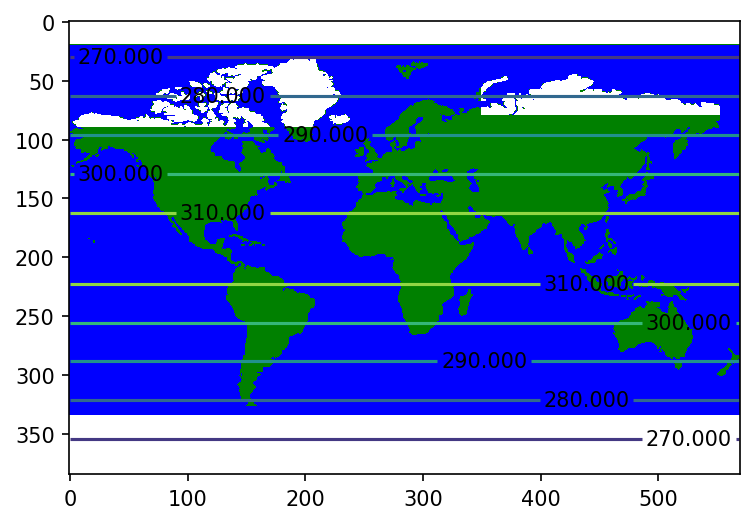

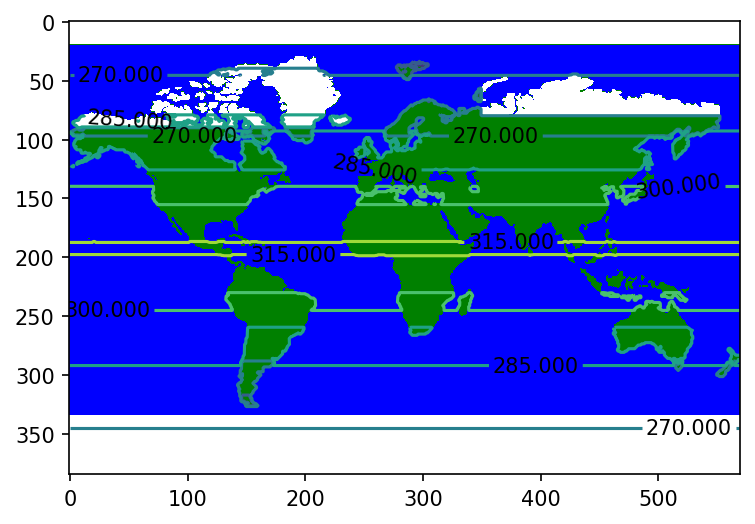

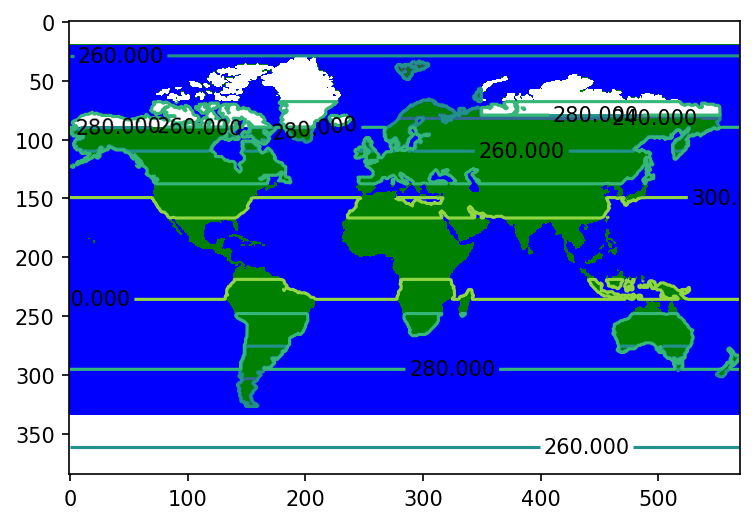

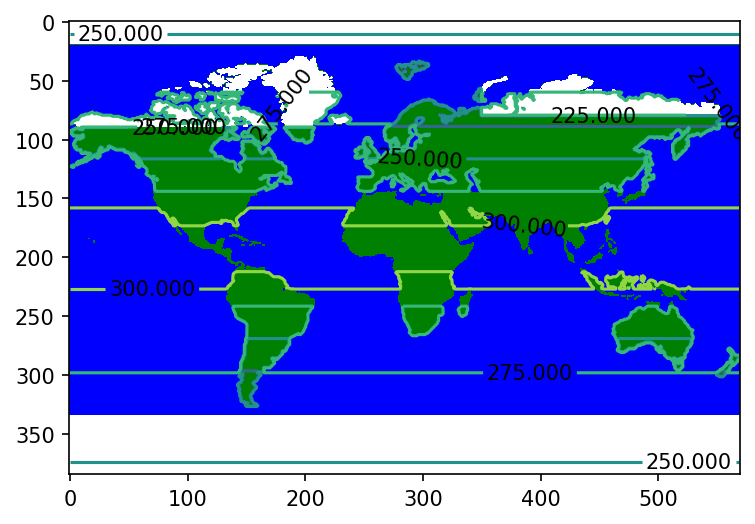

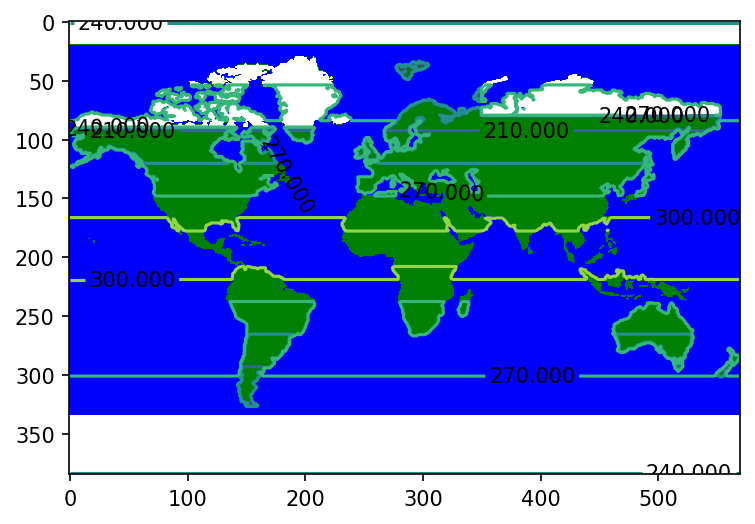

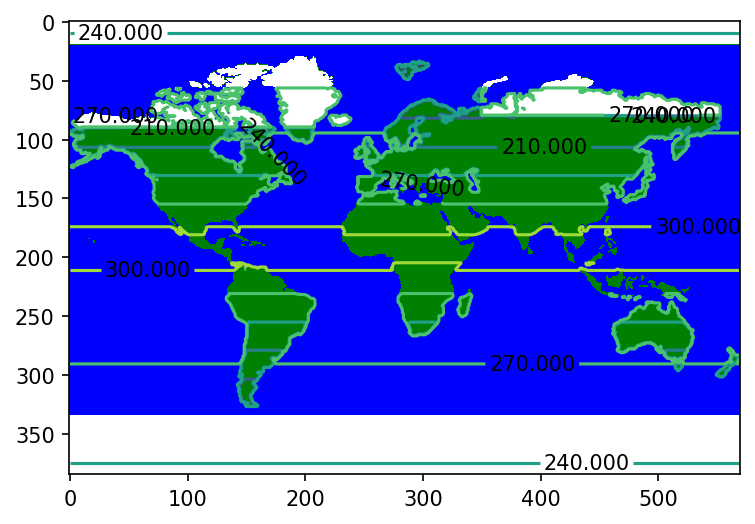

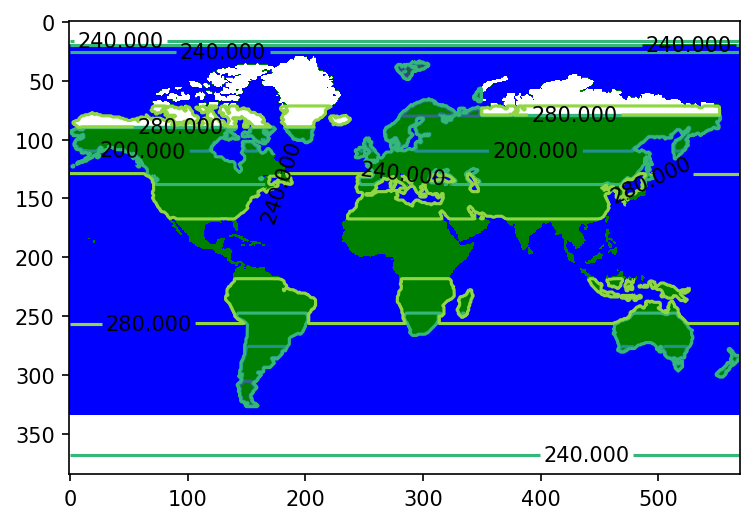

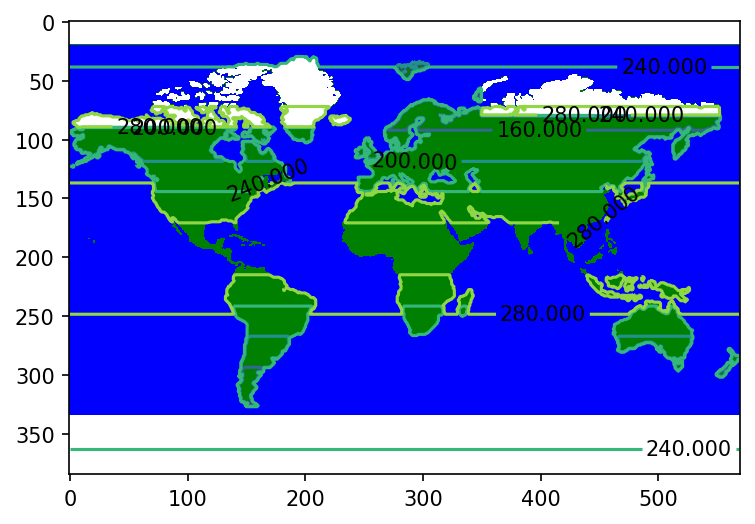

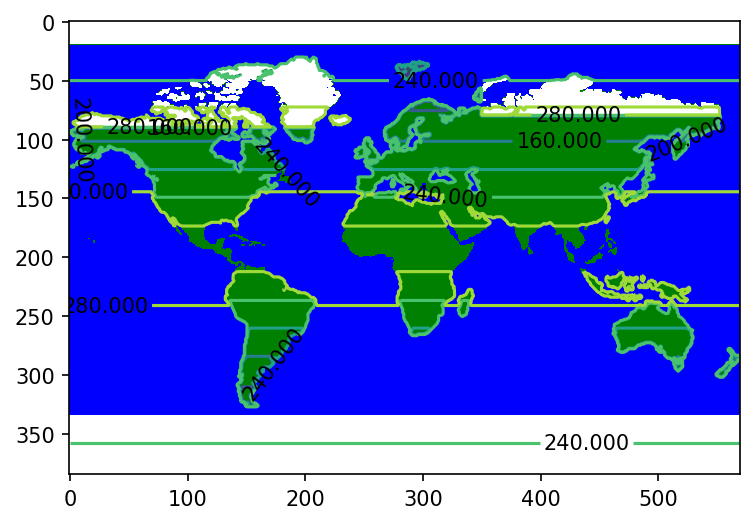

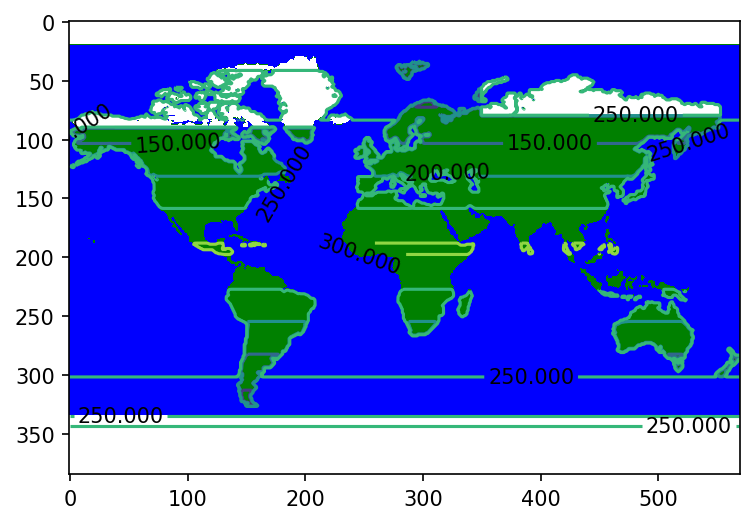

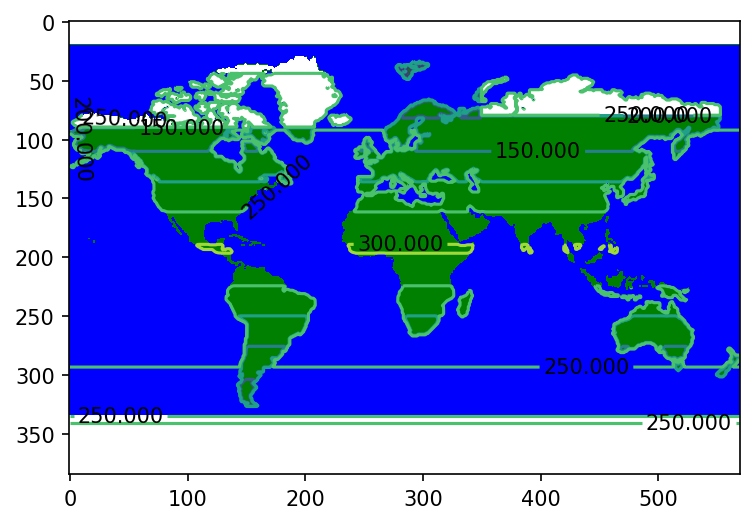

In [29]:
mapss = plask
colors = ['blue', 'green', 'white']
cmaps = ListedColormap(colors)
for i in range(len(tempti)):
    plt.figure(dpi =150)
    plt.imshow(mapss, cmap = cmaps)
    a = plt.contour(tempti[i], levels=5)
    plt.clabel(a , inline=True, fontsize=10, colors='black')
    #plt.imshow(tempti[i], alpha = .5)

In [140]:
print(insolation(5)[2,3])

0.6499999999999999


In [47]:
N = 100
a = np.random.uniform(size=(N,N))


In [48]:
%%timeit
da = (np.roll(a, 1) - np.roll(a, -1)) / 2

80.8 µs ± 351 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [49]:
%%timeit
db = np.empty((N,N))
for i in range(N):
    for j in range(N):
        db[i,j] = a[(i +1)%N, j] + a[(i-1)%N, j ]

6.44 ms ± 58.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
